In [1]:

import numpy as np

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential

import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/double_pendulum.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


GOOD. MINIMIZE DATA AND EPOCHS FOR NOW



In [7]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 600 #run w/ less data for better results
n_frames = 30
row = 128
col = 128
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float)

source_directory = "/tmp/double_pendulum"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(n_frames):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # Resize the image to 128x128
            img_resized = cv2.resize(img, (row, col))

            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply a threshold to create a binary mask
            _, binary_mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)

            # Invert the binary mask
            inverted_mask = cv2.bitwise_not(binary_mask)

            # Set all pixels to 0 where the mask is black
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # Convert the processed image to grayscale
            img_normalized = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
            img_normalized = img_normalized / 255.0

            # Add salt and pepper noise
            img_noisy = random_noise(img_normalized, mode='s&p', amount=0.05)

            # Normalize the pixel values to the range [0, 1]
            # img_noisy = img_noisy / 255.0

            # Assign the processed image to the dataset
            dataset[folder_num][idx] = img_noisy

In [8]:
dataset = dataset[..., np.newaxis]
dataset.shape

(600, 30, 128, 128, 1)

In [9]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]


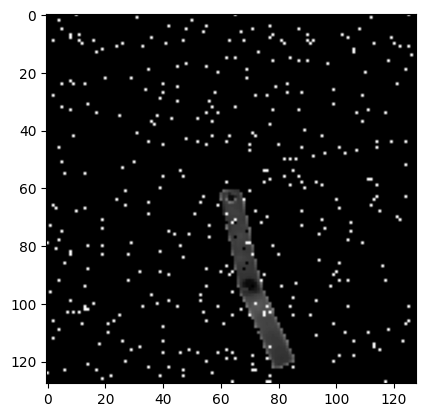

In [10]:
# Show example image
plt.imshow(dataset[79][0], cmap='gray')
plt.show()

In [11]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten

seq = Sequential()

seq.add(ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

# seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))
# seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# Add Attention Layer
attention = Attention()
conv_lstm_output = seq.get_layer(index=-2).output
attention_result = attention([conv_lstm_output, conv_lstm_output])

# Add Global Average Pooling
pooled_attention = GlobalAveragePooling3D()(attention_result)
# Flatten the conv_lstm_output
flattened_conv_lstm = Flatten()(conv_lstm_output)

# Reshape the attention output
reshaped_attention = Reshape((1, 1, 64))(pooled_attention)

# Flatten the reshaped_attention
flattened_attention = Flatten()(reshaped_attention)

# Concatenate the flattened original output and the flattened reshaped attention
combined = concatenate([flattened_conv_lstm, flattened_attention])

# Continue with the final Conv3D layer
seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


In [12]:
# Define some callbacks to improve training.


early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 15
batch_size = 1

# Fit the model to the training data.
# model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )

seq.fit(X[:500], y[:500], batch_size=1,
        epochs=epochs, validation_split=0.1,callbacks=[early_stopping, reduce_lr])

Epoch 1/15
480/480 [==============================] - 293s 570ms/step - loss: 0.0839 - accuracy: 0.9561 - val_loss: 2.4018 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 2/15
480/480 [==============================] - 271s 565ms/step - loss: 0.0217 - accuracy: 0.9720 - val_loss: 0.0224 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 3/15
480/480 [==============================] - 271s 564ms/step - loss: 0.0214 - accuracy: 0.9720 - val_loss: 0.0218 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 4/15
480/480 [==============================] - 271s 564ms/step - loss: 0.0212 - accuracy: 0.9720 - val_loss: 0.0213 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/15
480/480 [==============================] - 271s 564ms/step - loss: 0.0211 - accuracy: 0.9720 - val_loss: 0.0211 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/15
480/480 [==============================] - 271s 565ms/step - loss: 0.0211 - accuracy: 0.9720 - val_loss: 0.0230 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 7/15
480/480 [==========================

1/1 [==============================] - 0s 166ms/step


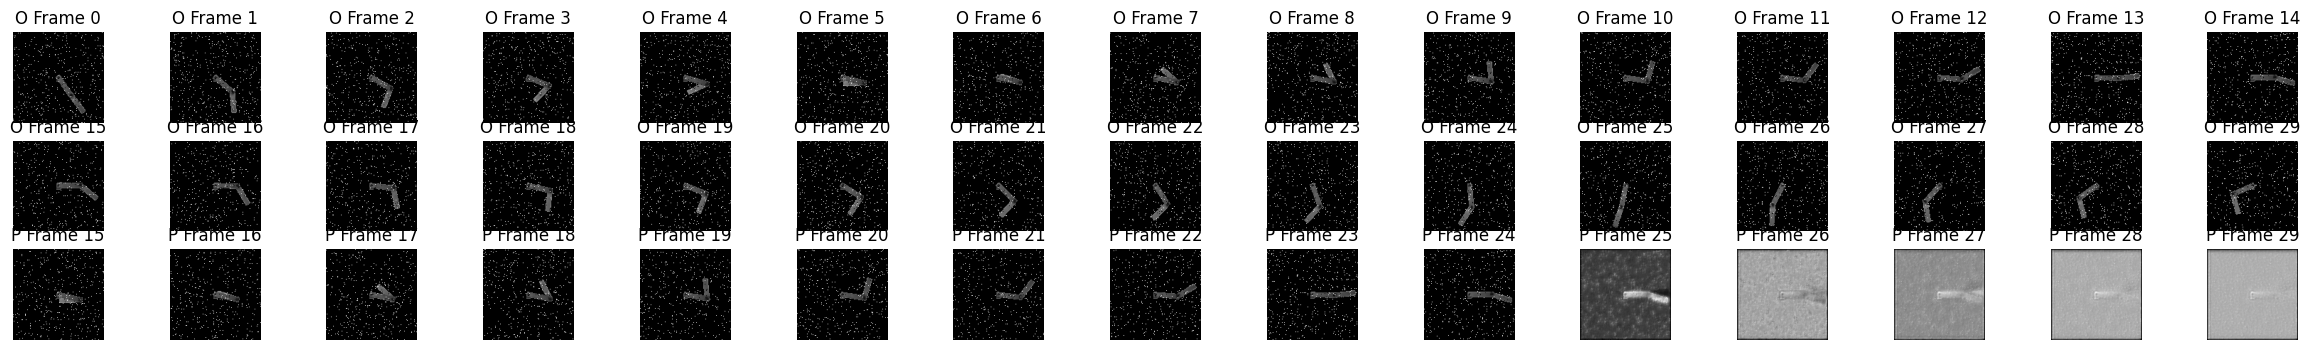

1/1 [==============================] - 0s 153ms/step


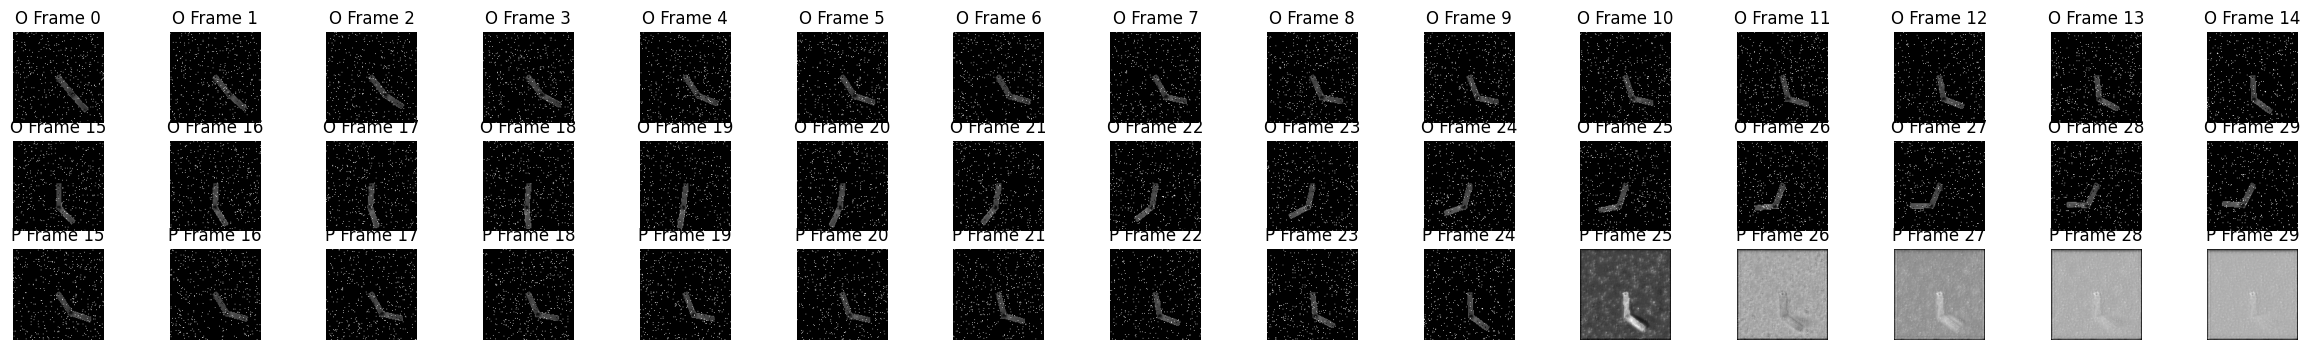

1/1 [==============================] - 0s 150ms/step


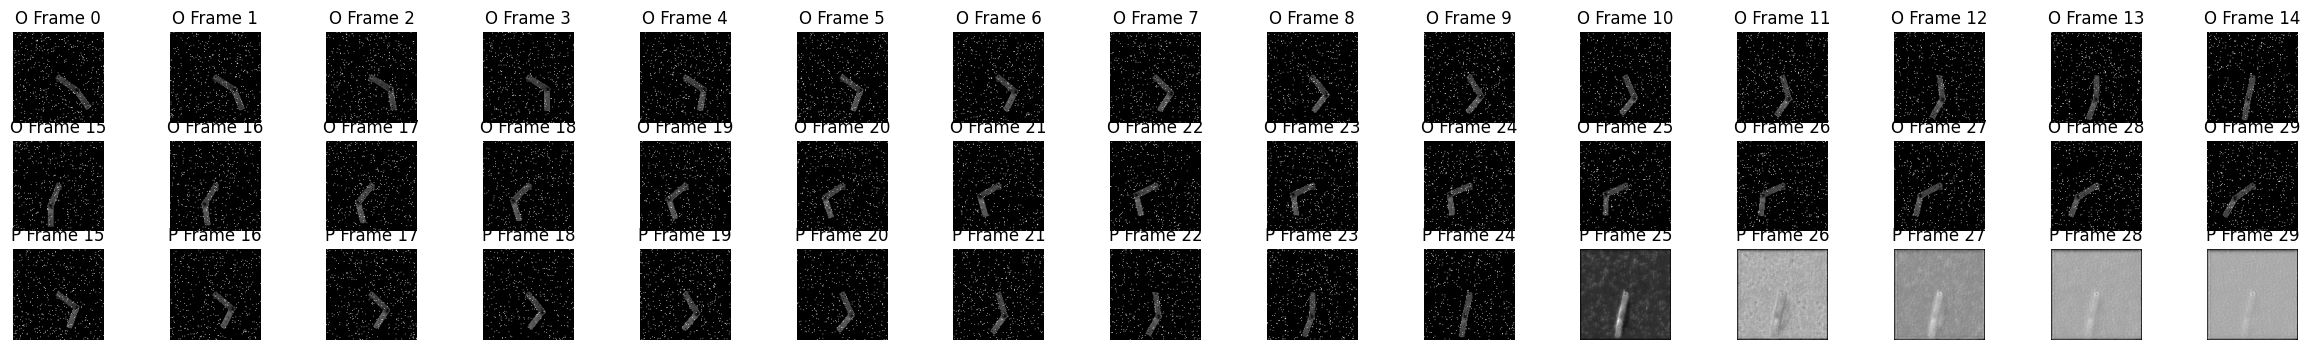

1/1 [==============================] - 0s 149ms/step


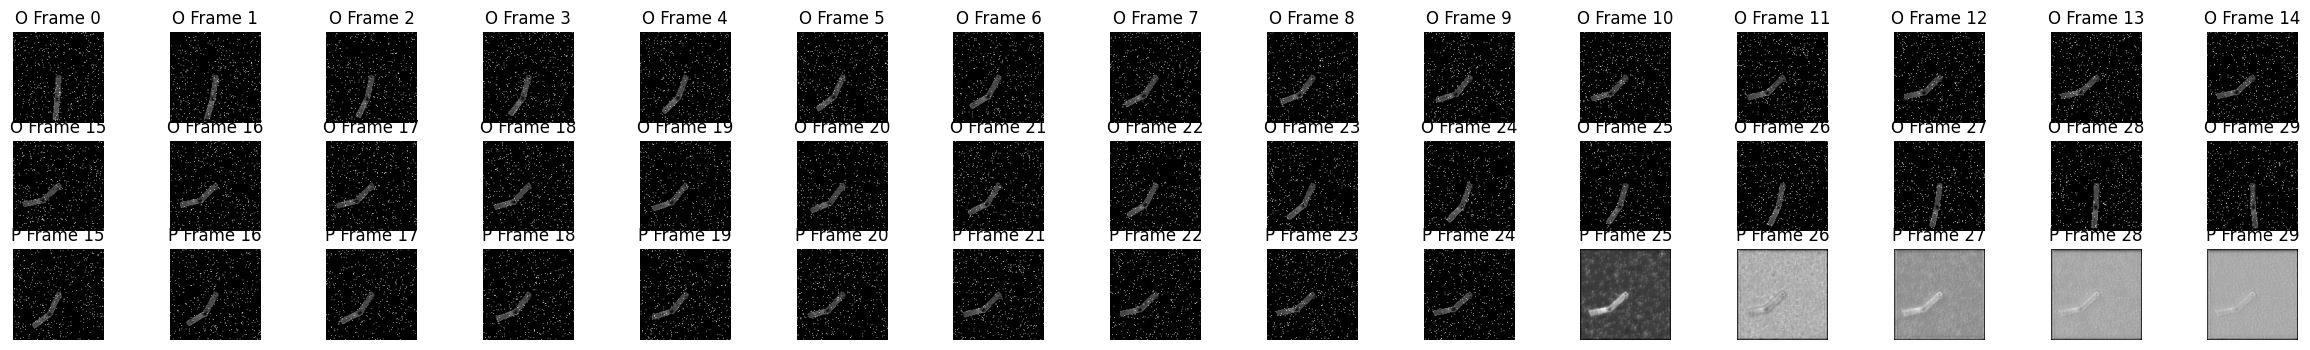

1/1 [==============================] - 0s 150ms/step


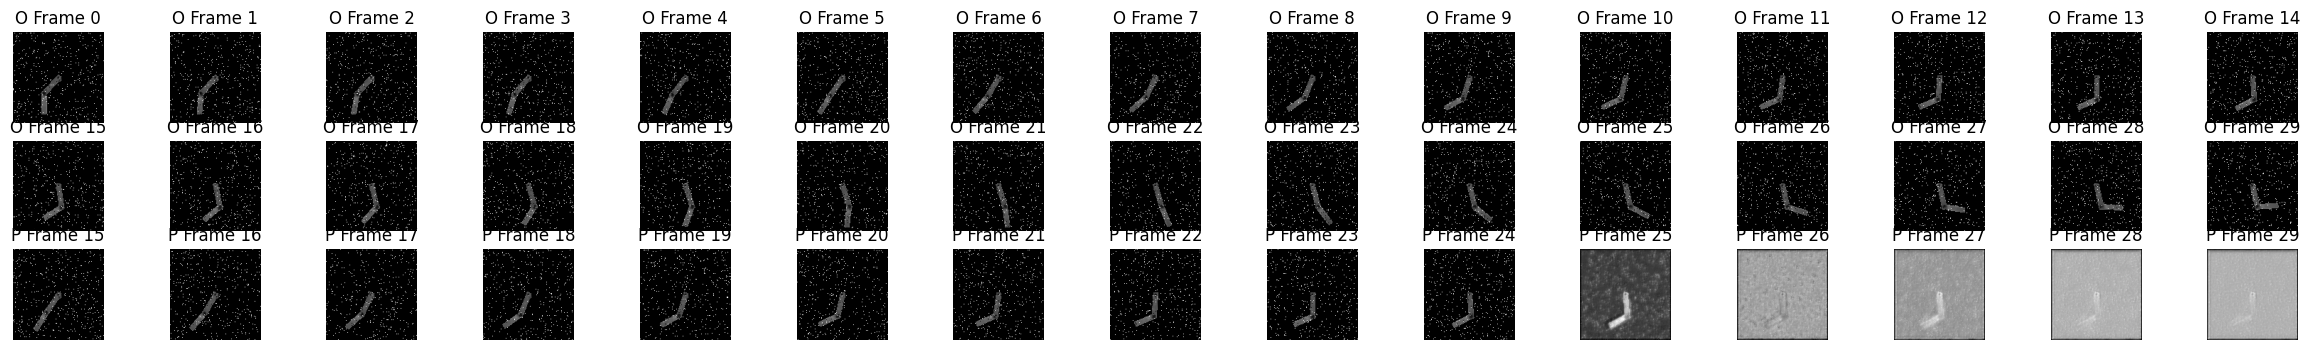

In [19]:
import random
from matplotlib.colors import LinearSegmentedColormap

# cmap = LinearSegmentedColormap.from_list("custom_colormap", ["black", "gray", "white"])

# for 300 training
for i in range(5):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(550, 599)]

    # Pick the first/last ten frames from the example.
    frames = example[:15, ...] #first 15
    original_frames = example[15:, ...] #last 15
    ogog_frames = example[:15,...] #first 15, unadultered

    # Predict a new set of 10 frames.
    for _ in range(15):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(3, 15, figsize=(30, 4))

    for idx, ax in enumerate(axes[0]):
          ax.imshow(ogog_frames[idx], cmap='gray')
          ax.set_title(f"O Frame {idx}")
          ax.axis("off")
    # Plot the original frames.
    for idx, ax in enumerate(axes[1]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"O Frame {idx + 15}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[2]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"P Frame {idx + 15}")
        ax.axis("off")

    # Display the figure.
    index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()

In [ ]:
import random
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

# cmap = LinearSegmentedColormap.from_list("custom_colormap", ["black", "gray", "white"])

# Create a PDF file to save the figures
with PdfPages('/output_frames_v14.pdf') as pdf:
    # for 300 training
    for i in range(30):
        # Select a random example from the validation dataset.
        example = dataset[random.randrange(550, 599)]

        # Pick the first/last ten frames from the example.
        frames = example[:15, ...]  # first 15
        original_frames = example[15:, ...]  # last 15
        ogog_frames = example[:15, ...]  # first 15, unadulterated

        # Predict a new set of 10 frames.
        for _ in range(15):
            # Extract the model's prediction and post-process it.
            new_prediction = seq.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # Extend the set of prediction frames.
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # Construct a figure for the original and new frames.
        fig, axes = plt.subplots(3, 15, figsize=(30, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx}")
            ax.axis("off")
        # Plot the original frames.
        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx + 15}")
            ax.axis("off")

        # Plot the new frames.
        new_frames = frames[5:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"P Frame {idx + 15}")
            ax.axis("off")

        # Display the figure.
        pdf.savefig()
        plt.close()

1/1 [==============================] - 0s 151ms/step


In [50]:
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Create a PDF file to save the images
pdf_filename = "/output_frames_leela_v14.pdf"
pdf_pages = PdfPages(pdf_filename)

# for 300 training
for i in range(30):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(550, 599)]

    # Pick the first/last 5 frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Save the figure to the PDF file
    pdf_pages.savefig(fig)
    plt.close()

# Close the PDF file
pdf_pages.close()
print(f"PDF saved to {pdf_filename}")

1/1 [==============================] - 0s 40ms/step
PDF saved to /output_frames_leela_v13.pdf


In [14]:
seq.save('/model_leela_v14.keras')